#Named Entity Recognition (NER) and Entity Insights from Media Cloud News Titles

##Introduction

This notebook performs Named Entity Recognition (NER) on media news titles collected from the Media Cloud dataset (2020–2025).
It aims to extract key entities such as people, organizations, and locations that dominate English-language news coverage.


## Justification and Design Decisions

###Why NER?
Named Entity Recognition (NER) helps identify key actors (e.g., people, organizations, locations) mentioned in media headlines.
While sentiment analysis captures emotional polarity, NER adds a semantic layer — revealing who or what the news is about.
We use spaCy’s large English model (en_core_web_lg) because it offers high accuracy on general-domain text like news headlines.

###Why these methods?

spaCy’s pre-trained model eliminates the need for labeled data.

Using Counter allows quick frequency counts to highlight prominent entities.

Visualizing entity frequencies helps detect dominant narratives or coverage bias.

##Setup and Library Imports

In [29]:
# Core Libraries
import pandas as pd
import re
from collections import Counter

# NLP
import spacy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_colwidth', 150)
sns.set(style='whitegrid')


##Load and Inspect Dataset

The dataset comes from Media Cloud, containing multilingual news titles.
We focus only on English titles for this NER task.

In [30]:
# Load Media Cloud dataset
media_cloud = pd.read_csv("mediacloud-2020-2025-dataset.csv")

# Inspect
print("Dataset shape:", media_cloud.shape)
print(media_cloud.head(3))

# Filter for English titles
media_cloud = media_cloud[media_cloud['language'] == 'en'].copy()
print("Filtered English titles:", media_cloud.shape)


Dataset shape: (35399, 8)
                                                                 id  \
0  1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f12970f30a427f0f7efb4d   
1  e6a47f0c7b6de768d799e603b5797ca432f9af6903de7bea1dd97d2b08228311   
2  8061d40a29f0fcf33e6906573a72389a4c0a0cc136522cf1c04e3d214c6f4119   

                       indexed_date language      media_name       media_url  \
0  2025-11-03 00:22:19.404264+00:00       en  techcrunch.com  techcrunch.com   
1  2025-11-02 23:17:22.553191+00:00       en    livemint.com    livemint.com   
2  2025-11-02 21:51:34.827292+00:00       en      apnews.com      apnews.com   

  publish_date  \
0   2025-11-02   
1   2025-11-02   
2   2025-11-02   

                                                                                             title  \
0            Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation   
1                   Here's why India’s AI content draft rules miss the mark on consumer pro

###Text Cleaning

We apply minimal cleaning, just normalization and removal of parentheses, to preserve the context needed for NER.

In [31]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    return text.strip()

media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)
print("Sample cleaned title:", media_cloud['clean_title'].iloc[0])


Sample cleaned title: google pulls gemma from ai studio after senator blackburn accuses model of defamation


##Load spaCy Model and Define Entity Extraction Function

###Justification:

* We use the en_core_web_lg model for high-accuracy, general-domain NER.

* It recognizes entities like PERSON, ORG, GPE, DATE, etc., which are particularly relevant in media text.

* Using a pre-trained model saves time and avoids the need for labeled data.

In [25]:
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("Model not found. Installing en_core_web_lg ...")
    !python -m spacy download en_core_web_lg
    nlp = spacy.load("en_core_web_lg")

print("spaCy model loaded successfully!")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER
media_cloud['Named_Entities'] = media_cloud['title'].apply(extract_entities)

print("\n--- Sample NER Results ---")
print(media_cloud[['title', 'Named_Entities']].head(10))


spaCy model loaded successfully!

--- Sample NER Results ---
                                                                                                                                                  title  \
0                                                                 Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation   
1                                                                        Here's why India’s AI content draft rules miss the mark on consumer protection   
2                                                       Who is Zico Kolter? A professor leads OpenAI safety panel with power to halt unsafe AI releases   
4                                                                           Like maple syrup and hockey, AI must become a part of our national identity   
5                                   The professor leading OpenAI's safety panel may have one of the most important roles in the tech industry right now   
6   I spo

##Exploration: Top Entities

Why:
Counting entity frequencies helps identify who or what dominates the media conversation.

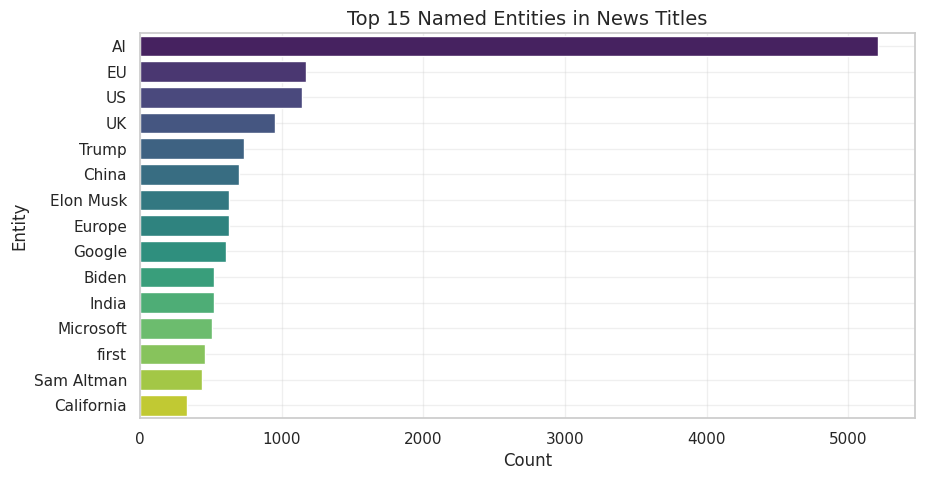

In [26]:
all_entities = [ent for entities in media_cloud['Named_Entities'] for ent, _ in entities]
entity_counts = Counter(all_entities)

entity_df = pd.DataFrame(entity_counts.most_common(15), columns=['Entity', 'Count'])

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Entity', hue='Entity', data=entity_df, palette='viridis', legend=False)
plt.title('Top 15 Named Entities in News Titles', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Entity')
plt.grid(alpha=0.3)
plt.show()


###Analysis:

This plot surfaces the most frequently mentioned entities, usually high-profile figures, organizations, or countries.  

In this dataset, entities such as **AI**, **EU**, **US**, and **UK** dominate, reflecting how geopolitical and technological topics shape the news agenda.  
Mentions of figures like **Elon Musk**, **Biden**, and **Trump** highlight personality-driven coverage, while the presence of corporations such as **Google** and **Microsoft** underscores the strong influence of the tech sector in recent media narratives.


##Entity Type Distribution

Goal: Understand what types of entities (people, organizations, places, etc.) appear most often.

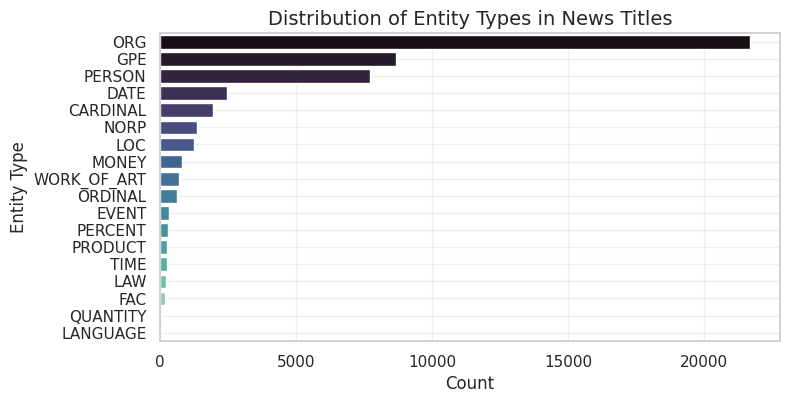

In [27]:
# Extract and count entity labels
entity_labels = [label for entities in media_cloud['Named_Entities'] for _, label in entities]
label_counts = Counter(entity_labels)

label_df = pd.DataFrame(label_counts.items(), columns=['Entity_Label', 'Count']).sort_values('Count', ascending=False)

# Visualization (fixed for future versions)
plt.figure(figsize=(8, 4))
sns.barplot(x='Count', y='Entity_Label', hue='Entity_Label', data=label_df, palette='mako', legend=False)
plt.title('Distribution of Entity Types in News Titles', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.grid(alpha=0.3)
plt.show()


### Analysis

This chart illustrates how different types of named entities are distributed in news titles.  
**PERSON** and **ORG** typically dominate, reflecting individuals and institutions that drive news narratives.  
**GPE (Geopolitical Entity)** highlights the most covered countries or cities, showing where attention is geographically concentrated.

This helps map the balance between **who** and **where** in global media attention.  
The presence of other types like **DATE**, **CARDINAL**, and **NORP** (nationalities or political groups) adds contextual framing linking events to specific timeframes or social categories.


##Entity Co-occurrence Network (Knowledge Graph)

Graph has 844 nodes and 1859 edges


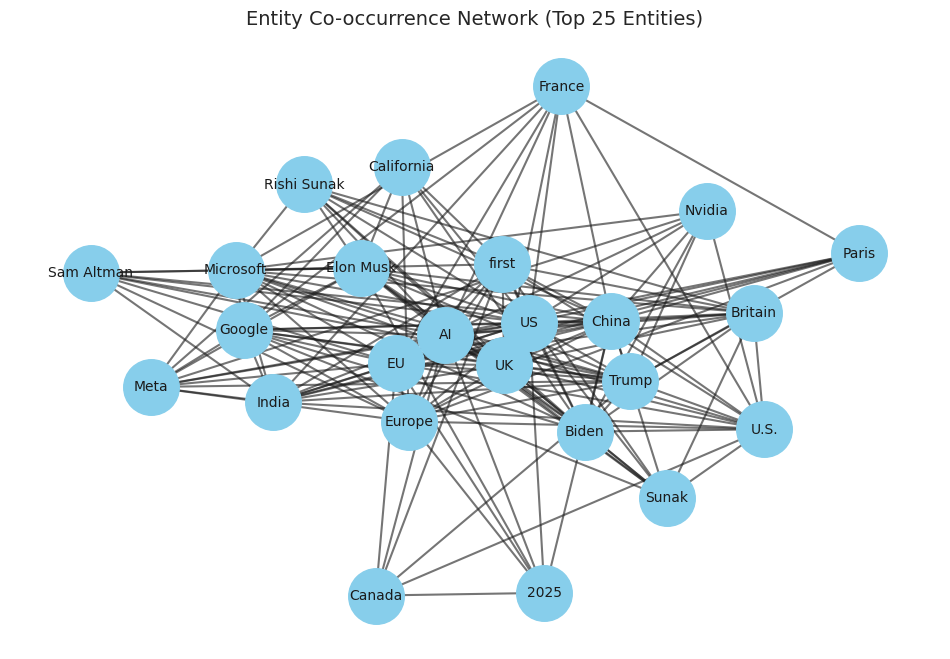

In [28]:
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

# Extract all entity lists per title
entity_lists = media_cloud['Named_Entities'].apply(lambda ents: [e[0] for e in ents])

# Build co-occurrence pairs (entities appearing together in one title)
co_occurrence_pairs = []
for entity_list in entity_lists:
    if len(entity_list) > 1:
        pairs = list(combinations(sorted(set(entity_list)), 2))
        co_occurrence_pairs.extend(pairs)

# Count co-occurrences
co_occurrence_counts = Counter(co_occurrence_pairs)

# Create graph
G = nx.Graph()
for (e1, e2), count in co_occurrence_counts.items():
    if count >= 3:  # filter weak connections
        G.add_edge(e1, e2, weight=count)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Visualize small subgraph for clarity
top_nodes = dict(sorted(G.degree, key=lambda x: x[1], reverse=True)[:25])
H = G.subgraph(top_nodes.keys())

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(H, k=0.5, seed=42)
nx.draw_networkx_nodes(H, pos, node_color='skyblue', node_size=1600)
nx.draw_networkx_edges(H, pos, width=1.5, alpha=0.6)
nx.draw_networkx_labels(H, pos, font_size=10)
plt.title("Entity Co-occurrence Network (Top 25 Entities)", fontsize=14)
plt.axis("off")
plt.show()


###Analysis

This graph visualizes how frequently entities co-occur within the same news title, effectively mapping the **semantic and topical proximity** between the most mentioned names in the dataset.  

With **844 nodes** (unique entities) and **1,859 edges** (co-occurrences), the network reveals several key structural patterns:  

- **High Connectivity of Core Nodes:**  
  Central entities like *AI*, *US*, *UK*, *EU*, and *China* form dense clusters, showing that these topics frequently appear together across news contexts — particularly in discussions about technology, geopolitics, and regulation.  

- **Emergence of Thematic Hubs:**  
  Sub-networks such as (*AI*, *Elon Musk*, *Microsoft*, *Google*, *Meta*) represent the **tech and AI ecosystem**, while others like (*US*, *China*, *Europe*, *UK*) correspond to **geopolitical or policy-focused** narratives.  

- **Cross-Domain Links:**  
  The presence of bridges between technology and politics (e.g., *Biden*, *AI*, *Europe*, *Nvidia*) indicates that AI has transcended purely technical reporting, becoming a central theme in economic and political coverage.   

Overall, this co-occurrence network highlights **how global media narratives are interconnected**, centering around AI and major geopolitical actors, while still encompassing a wide array of less prominent entities that enrich the thematic complexity of modern news discourse.
